In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials,align_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
import logging
from scipy import fft,signal
import os
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from multiprocessing import Pool
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.structures.neuron_data import NeuronData
import pandas as pd

from ephysvibe.structures.lfp_data import LfpData
from ephysvibe.spike_sorting import config
import h5py

In [2]:
# %matplotlib widget

In [2]:
sp_path = "/home/INT/losada.c/Documents/session_struct/lip/spikes/2023-03-03_10-59-32_Riesling_lip_e1_r1_sp.h5"
neu_path = "/home/INT/losada.c/Documents/session_struct/v4/neurons/2023-03-03_10-59-32_Riesling_v4_e1_r1_mua7_neu.h5"
bhv_path = "/home/INT/losada.c/Documents/session_struct/bhv/2023-03-03_10-59-32_Riesling_e1_r1_bhv.h5"

In [4]:
bhv = BhvData.from_python_hdf5(bhv_path)
sp_data = SpikeData.from_python_hdf5(sp_path)

In [3]:
neu_data = NeuronData.from_python_hdf5(neu_path)

In [6]:
neu_data.cluster_group

'mua'

In [7]:
neu_data.cluster_number

array(7)

In [14]:
neu_data.pos_code

array([121., 123., 123., ...,  -1.,   1.,   1.])

In [8]:
neu_data.date_time

'2023-03-03_10-59-32'

In [13]:
# select correct trials, block one, inside RF, and align with sample onset 
sp_sample_on,mask_in = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block= 1,
    select_pos= 1,
    event ="sample_on",
    time_before = 500,
    correct_trials= True,
)
sp_sample_on_in = sp_sample_on[:,300:1200]

In [15]:
sample_id = neu_data.sample_id[mask_in]
o1_c1_idx_in, o1_c5_idx_in, o5_c1_idx_in, o5_c5_idx_in, o0_c0_idx_in = select_trials.get_trials_by_sample(sample_id)

/tmp/ipykernel_141867/4017640199.py:5: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cols,rows+60*i, marker='|', alpha=1,edgecolors='none',color=colors[i])


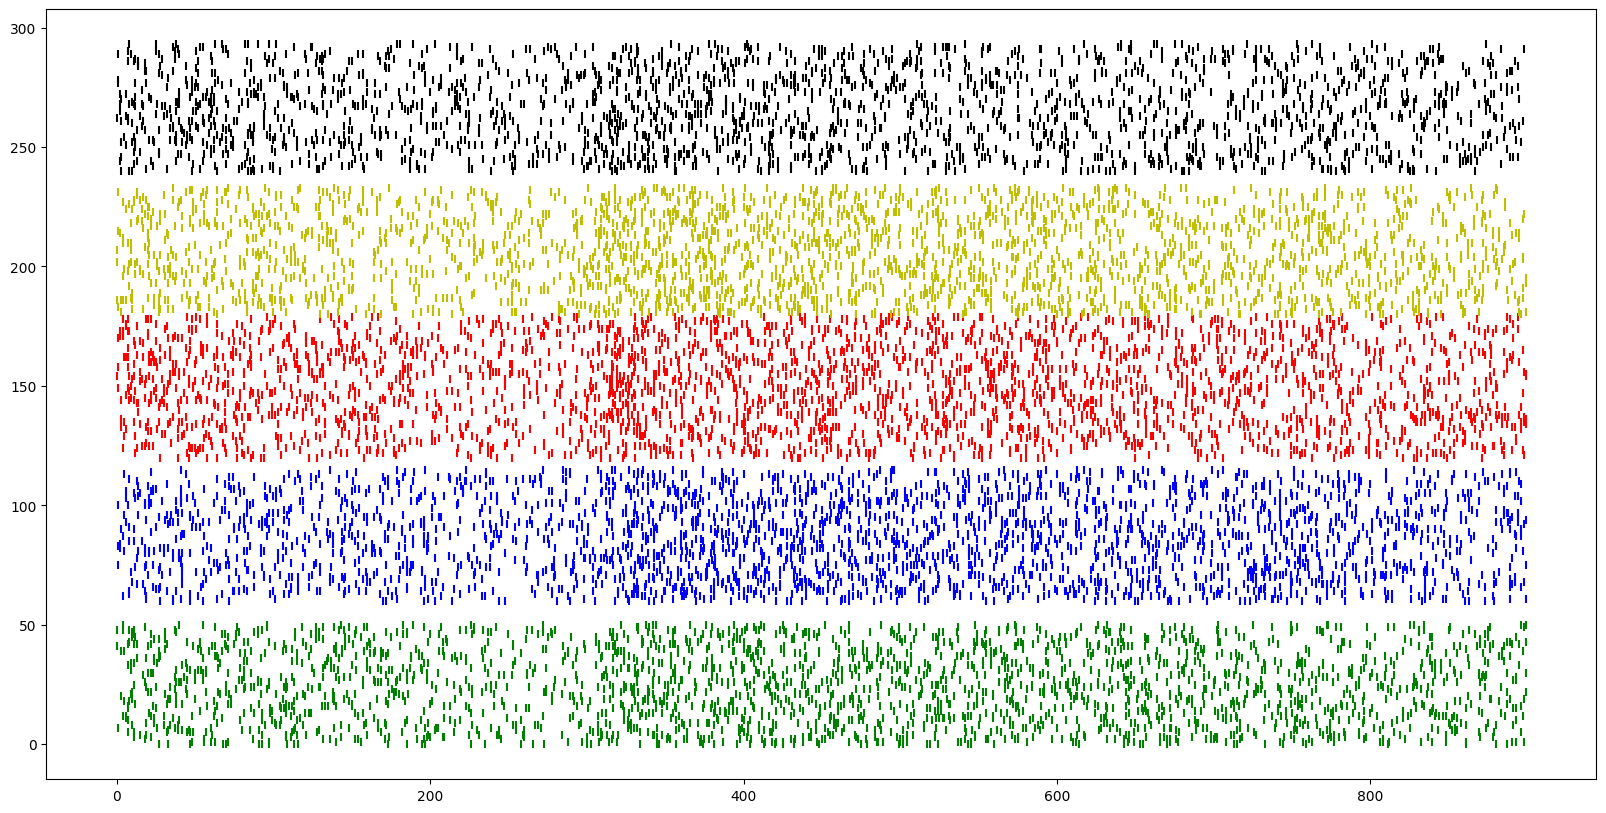

In [11]:
colors=['g','b','r','y','k']
fig, ax = plt.subplots(figsize=(20, 10), sharey=True)
for i,idx in enumerate([o1_c1_idx, o1_c5_idx, o5_c1_idx, o5_c5_idx, o0_c0_idx]):
    rows,cols = np.where(sp_sample_on[idx]==1)
    ax.scatter(cols,rows+60*i, marker='|', alpha=1,edgecolors='none',color=colors[i])

In [ ]:
neu_data.code_samples[mask][np.where(neu_data.code_numbers[mask]==task_constants.EVENTS_B1['sample_on'],True,False)]

array([1582., 1542., 1551., 1539., 1450., 1532., 1696., 1485., 1567.,
       1527., 1379., 1591., 1379., 1551., 1379., 1579., 1779., 1638.,
       1550., 1373., 1473., 1539., 1473., 1521., 1545., 1379., 1650.,
       1720., 1556., 1539., 1579., 1379., 1480., 1421., 1508., 1562.,
       1586., 1508., 1533., 1544., 1592., 1521., 1379., 1510., 1520.,
       1591., 1379., 1579., 1473., 1380., 1379., 1379., 1556., 1380.,
       1557., 1374., 1379., 1497., 1510., 1474., 1562., 1379., 1504.,
       1544., 1380., 1574., 1457., 1380., 1551., 1591., 1380., 1533.,
       1591., 1591., 1473., 1497., 1727., 1520., 1374., 1556., 1379.,
       1379., 1497., 1539., 1591., 1375., 1514., 1551., 1597., 1480.,
       1479., 1520., 1521., 1532., 1586., 1374., 1555., 1568., 1480.,
       1474., 1709., 1379., 1551., 1602., 1755., 1374., 1585., 1550.,
       1379., 1380., 1461., 1508., 1379., 1539., 1503., 1585., 1626.,
       1379., 1379., 1374., 1515., 1649., 1397., 1379., 1586., 1562.,
       1610., 1573.,

In [ ]:
neu_data.code_samples

array([[1000., 1007., 1017., ...,   nan,   nan,   nan],
       [1000., 1003., 1013., ...,   nan,   nan,   nan],
       [1000., 1003., 1009., ..., 4711.,   nan,   nan],
       ...,
       [1000., 1004., 1015., ...,   nan,   nan,   nan],
       [1000., 1003., 1009., ...,   nan,   nan,   nan],
       [1000., 1004., 1010., ..., 5281., 5282.,   nan]])

In [ ]:
neu_data.trial_error

array([5., 0., 0., ..., 4., 3., 4.])

In [ ]:
sp_data.sp_samples.shape

(37, 5893894)

In [ ]:
bhv.code_samples[:2,0].astype(int)

array([1359501, 1361180])

In [ ]:
before_trial=1000
iti=1500 
next_trial=6000
trials_end = bhv.code_samples[np.where(bhv.code_numbers==18,True,False)]
trials_start = bhv.code_samples[:,0]
trials_max_duration = max(trials_end-trials_start)
trials_max_duration =int(trials_max_duration + before_trial + iti + next_trial)

In [ ]:
n_trials = trials_start.shape[0]
n_neurons = sp_data.sp_samples.shape[0]
tr_sp_data = np.full((n_trials,n_neurons,trials_max_duration),np.nan)

for i_t in range(n_trials):
    start_trial = (trials_start[i_t]-before_trial).astype(int)
    end_trial = (trials_end[i_t]+iti+next_trial).astype(int)
    if end_trial>sp_data.sp_samples.shape[1]:
        end_trial=sp_data.sp_samples.shape[1]
    tr_sp_data[i_t,:,:int(end_trial-start_trial)] = sp_data.sp_samples[:,start_trial:end_trial]
code_samples_trial = bhv.code_samples-bhv.code_samples[:,0].reshape(-1,1)+before_trial


In [ ]:
code_samples_trial

array([[1000., 1022., 1151., ...,   nan,   nan,   nan],
       [1000., 1014., 1020., ...,   nan,   nan,   nan],
       [1000., 1014., 1306., ...,   nan,   nan,   nan],
       ...,
       [1000., 1004., 1014., ...,   nan,   nan,   nan],
       [1000., 1004., 1015., ...,   nan,   nan,   nan],
       [1000., 1002., 1015., ...,   nan,   nan,   nan]])

In [ ]:
tr_sp_data.shape

(1034, 37, 15198)

In [ ]:
SpikeData.indep_roll(arr=sp_data.sp_samples[:1], shifts=-bhv.code_samples[:1,0].astype(int), axis= 1)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
trials_start[0].astype(int)

1359501

In [ ]:
sp_data.sp_samples[:,bhv.code_samples[:,0].astype(int)].shape

(37, 1034)

In [ ]:
sp_data.sp_samples.shape

(37, 5893894)

In [ ]:
5893894-1359501

4534393

In [ ]:
bhv.code_samples[:,0].astype(int)

array([1359501, 1361180, 1364909, ..., 5879458, 5881517, 5883729])

In [ ]:
bhv.code_samples

array([[1359501., 1359523., 1359652., ...,      nan,      nan,      nan],
       [1361180., 1361194., 1361200., ...,      nan,      nan,      nan],
       [1364909., 1364923., 1365215., ...,      nan,      nan,      nan],
       ...,
       [5879458., 5879462., 5879472., ...,      nan,      nan,      nan],
       [5881517., 5881521., 5881532., ...,      nan,      nan,      nan],
       [5883729., 5883731., 5883744., ...,      nan,      nan,      nan]])

In [ ]:
bhv.code_numbers

array([[ 9., 35.,  8., ..., nan, nan, nan],
       [ 9., 35.,  8., ..., nan, nan, nan],
       [ 9., 35.,  8., ..., nan, nan, nan],
       ...,
       [ 9.,  7., 35., ..., nan, nan, nan],
       [ 9.,  7., 35., ..., nan, nan, nan],
       [ 9.,  7., 35., ..., nan, nan, nan]])

In [ ]:
sp_data.sp_samples

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
40*1000*60

2400000

/tmp/ipykernel_63109/3922085339.py:3: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(cols,rows, marker='|', alpha=1,edgecolors='none')


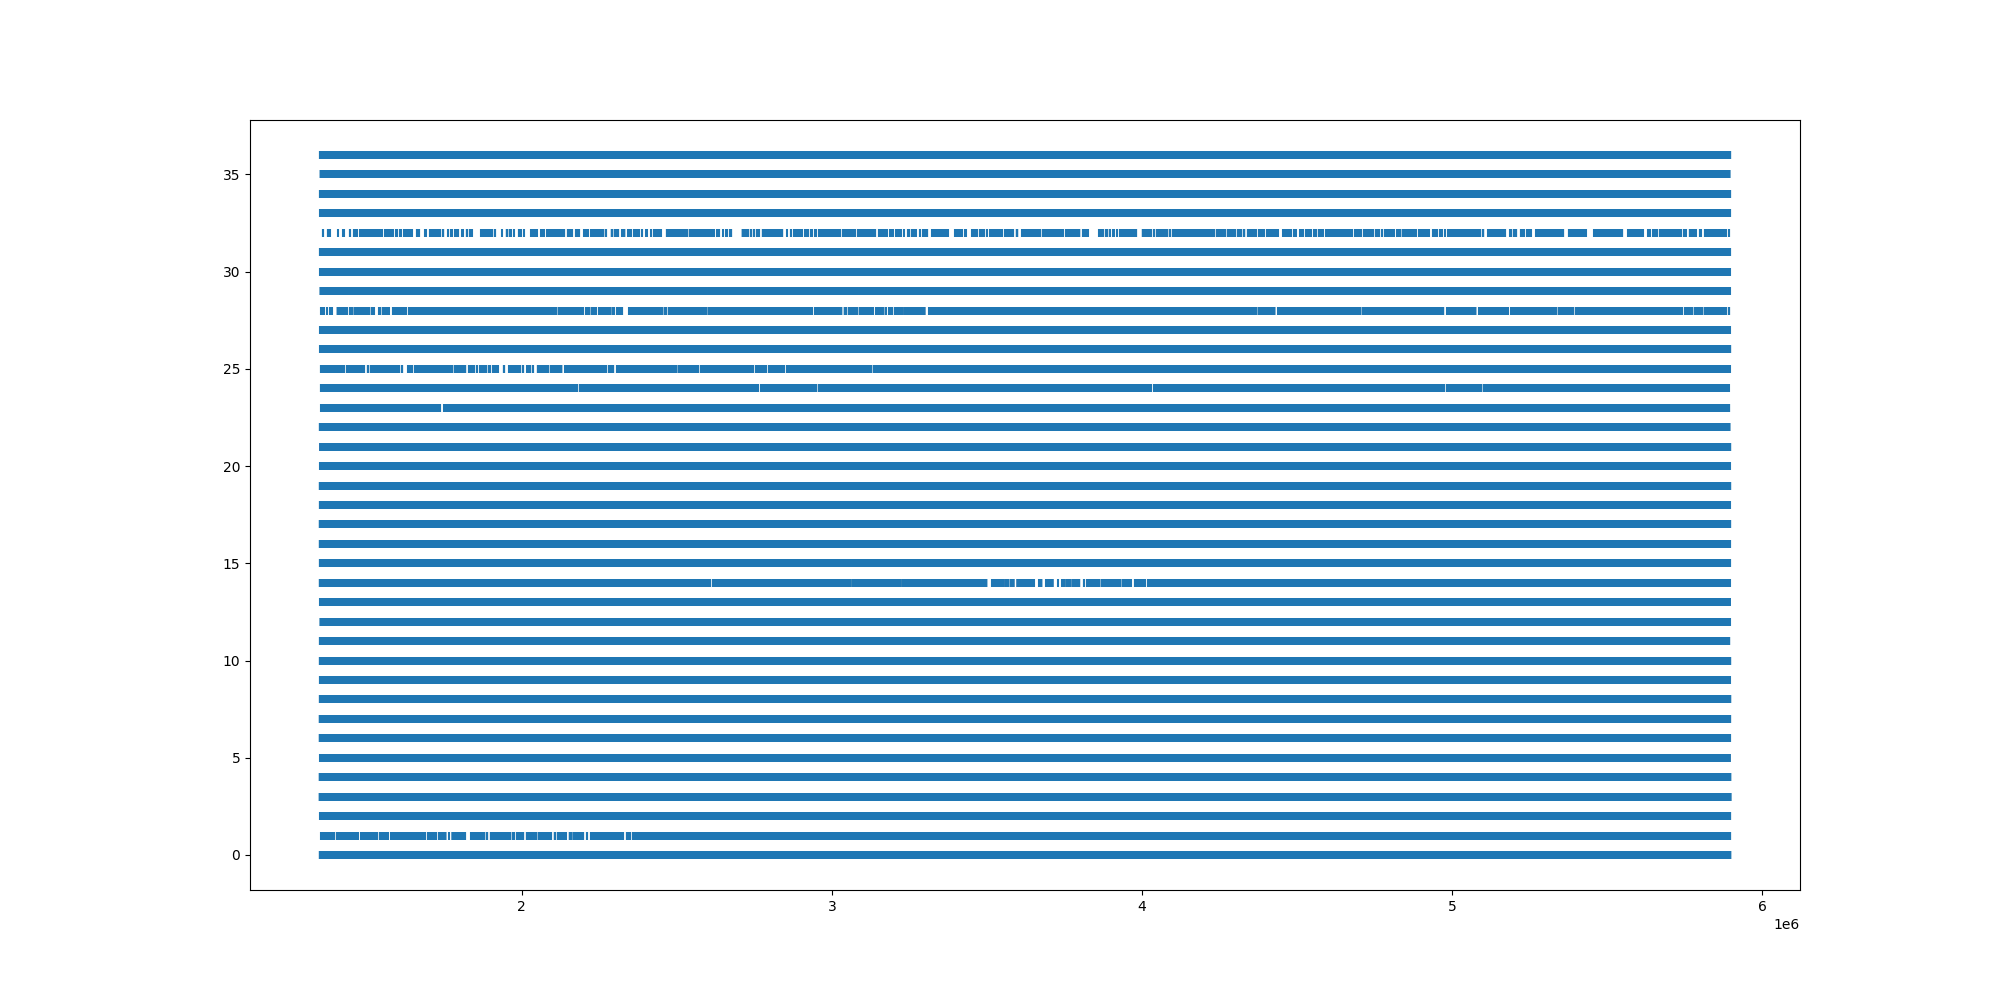

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10), sharey=True)
rows,cols = np.where(data.sp_samples==1)
ax.scatter(cols,rows, marker='|', alpha=1,edgecolors='none')

In [ ]:

bhv = BhvData.from_python_hdf5("/home/INT/losada.c/Documents/session_struct/bhv/2023-10-17_11-15-27_Riesling_e1_r1_bhv.h5")

In [ ]:
bhv.sta

AttributeError: 'BhvData' object has no attribute 'cod'

In [ ]:
fix_duration=200
step = 10

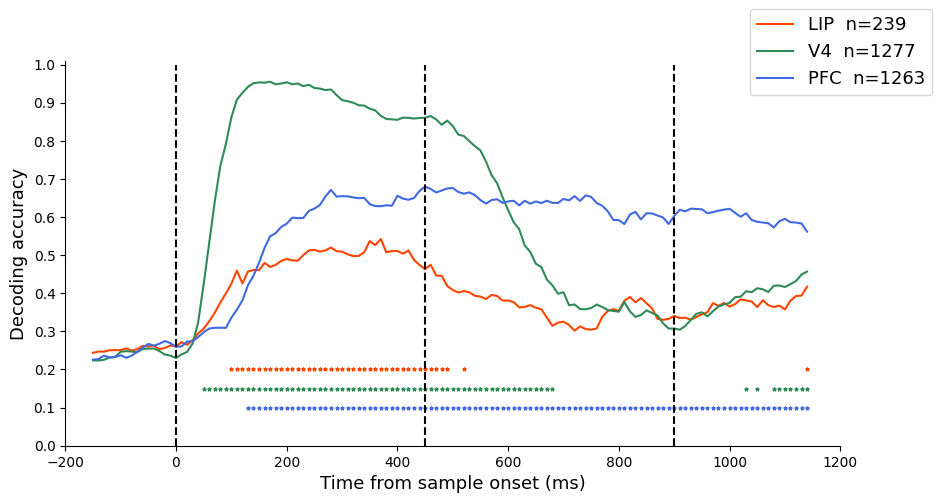

In [ ]:
path_lip = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_samples_1000it_all_in_win100.npy'
path_v4 = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/v4_samples_1000it_all_in_win100.npy'
path_pfc = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/pfc_samples_1000it_all_in_win100.npy'
#path_test = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_test.npy'
color=["#ff4500",'seagreen','royalblue']#,'y']
to_decode = "samples"
n_neurs=[239,1277,1263,112]
fig,ax = plt.subplots(figsize=(10,5))
for i,(path,area) in enumerate(zip([path_lip,path_v4,path_pfc],["LIP","V4","PFC"])):
    area = area + '  n='+ str(n_neurs[i])
    scores=np.load(path)[:,:130]
    x = ((np.arange(0, len(scores[0]))) - (fix_duration-50) / step) * 10
    ax.plot(x, np.array(scores).mean(axis=0), label=area,color=color[i])
    if to_decode == "samples":
        threshole = 0.25
    else:
        threshole = 0.5
    ss = np.sum(np.array(scores) <= threshole, axis=0) / np.array(scores).shape[0]
    mask_inf = ss <= 0.01
    mask_inf_5 = ss <= 0.05
    # stars
    ax.scatter(
        x[mask_inf_5],
        [threshole+0.05 - (0.1+i/20)] * len(x[mask_inf_5]),
        color=color[i],
        marker="*",
        s=6,
    )
    ax.set_ylim(0, 1.01)
    ax.set_xlim(-200,1200)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    # delete boundaries
    ax.spines["right"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
ax.vlines([0,450,900],0,1,'k','--')
ax.set_xlabel('Time from sample onset (ms)',fontsize=13)
ax.set_ylabel('Decoding accuracy',fontsize=13)
fig.legend(fontsize=13)

    # fig.suptitle(
    #     "%s, condition: %s, group: %s, %d neurons,window: %d, steps: %d"
    #     % (s_path[-2], in_out, cgroup, n_neurons, win_size, step)
    # )

In [ ]:
fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_sample_areas.png",format='png',bbox_inches="tight", transparent=True)
fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_sample_areas.svg",format='svg',bbox_inches="tight", transparent=True)

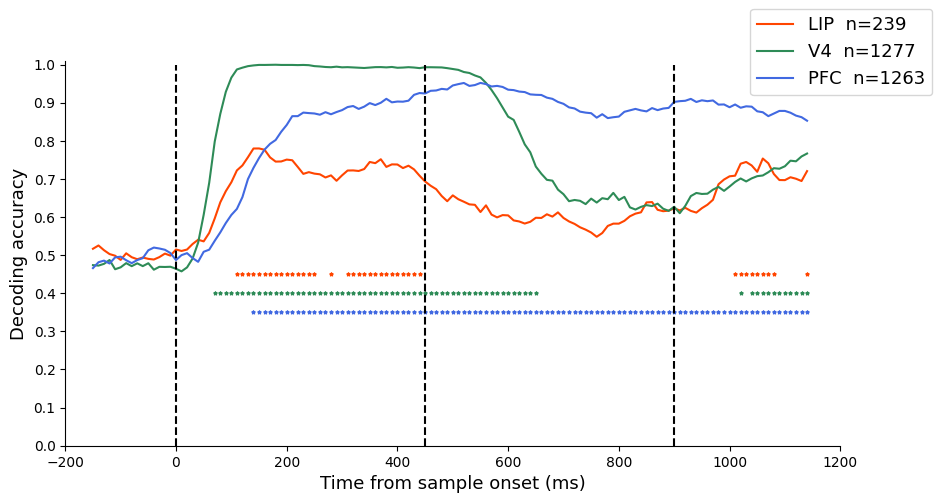

In [ ]:
path_lip = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_orientation_1000it_all_in_win100.npy'
path_v4 = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/v4_orientation_1000it_all_in_win100.npy'
path_pfc = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/pfc_orientation_1000it_all_in_win100.npy'
to_decode='orientation'
color=["#ff4500",'seagreen','royalblue']
n_neurs=[239,1277,1263]
fig,ax = plt.subplots(figsize=(10,5))
for i,(path,area) in enumerate(zip([path_lip,path_v4,path_pfc],["LIP","V4","PFC"])):
    area = area + '  n='+ str(n_neurs[i])
    scores=np.load(path)[:,:130]
    x = ((np.arange(0, len(scores[0]))) - (fix_duration-50) / step) * 10
    ax.plot(x, np.array(scores).mean(axis=0), label=area,color=color[i])
    if to_decode == "samples":
        threshole = 0.25
    else:
        threshole = 0.5
    ss = np.sum(np.array(scores) <= threshole, axis=0) / np.array(scores).shape[0]
    mask_inf = ss <= 0.01
    mask_inf_5 = ss <= 0.05
    # stars
    ax.scatter(
        x[mask_inf_5],
        [threshole+0.05- (0.1+i/20)] * len(x[mask_inf_5]),
        color=color[i],
        marker="*",
        s=6,
    )
    ax.set_ylim(0, 1.01)
    ax.set_xlim(-200,1200)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    # delete boundaries
    ax.spines["right"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
ax.vlines([0,450,900],0,1,'k','--')
ax.set_xlabel('Time from sample onset (ms)',fontsize=13)
ax.set_ylabel('Decoding accuracy',fontsize=13)
fig.legend(fontsize=13)

    # fig.suptitle(
    #     "%s, condition: %s, group: %s, %d neurons,window: %d, steps: %d"
    #     % (s_path[-2], in_out, cgroup, n_neurons, win_size, step)
    # )

In [ ]:
# fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_orientation_areas.png",format='png',bbox_inches="tight", transparent=True)
# fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_orientation_areas.svg",format='svg',bbox_inches="tight", transparent=True)

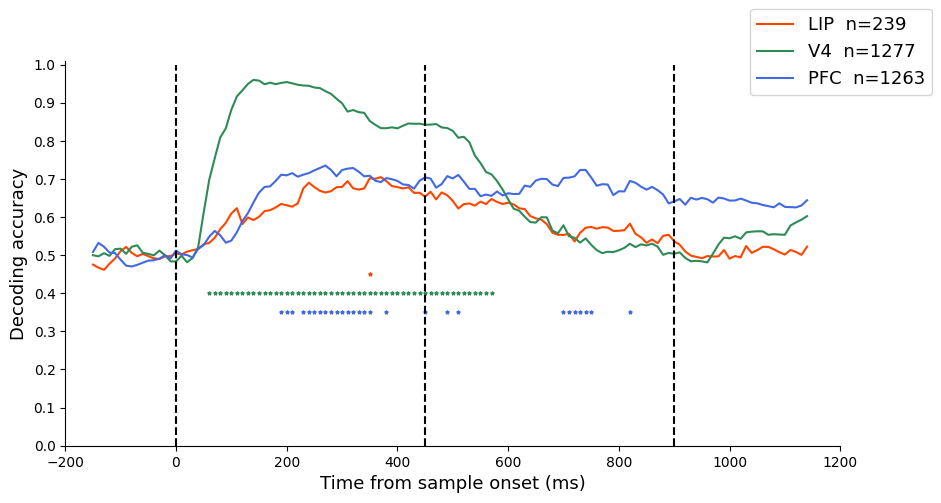

In [ ]:
path_lip = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_colors_1000it_all_in_win100.npy'
path_v4 = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/v4_colors_1000it_all_in_win100.npy'
path_pfc = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/pfc_colors_1000it_all_in_win100.npy'
to_decode='colors'
color=["#ff4500",'seagreen','royalblue']
n_neurs=[239,1277,1263]
fig,ax = plt.subplots(figsize=(10,5))
for i,(path,area) in enumerate(zip([path_lip,path_v4,path_pfc],["LIP","V4","PFC"])):
    area = area + '  n='+ str(n_neurs[i])
    scores=np.load(path)[:,:130]
    x = ((np.arange(0, len(scores[0]))) - (fix_duration-50) / step) * 10
    ax.plot(x, np.array(scores).mean(axis=0), label=area,color=color[i])
    if to_decode == "samples":
        threshole = 0.25
    else:
        threshole = 0.5
    ss = np.sum(np.array(scores) <= threshole, axis=0) / np.array(scores).shape[0]
    mask_inf = ss <= 0.01
    mask_inf_5 = ss <= 0.05
    # stars
    ax.scatter(
        x[mask_inf_5],
        [threshole+0.05- (0.1+i/20)] * len(x[mask_inf_5]),
        color=color[i],
        marker="*",
        s=6,
    )
    ax.set_ylim(0, 1.01)
    ax.set_xlim(-200,1200)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    # delete boundaries
    ax.spines["right"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
ax.vlines([0,450,900],0,1,'k','--')
ax.set_xlabel('Time from sample onset (ms)',fontsize=13)
ax.set_ylabel('Decoding accuracy',fontsize=13)
fig.legend(fontsize=13)

# fig.suptitle(
#     "%s, condition: %s, group: %s, %d neurons,window: %d, steps: %d"
#     % (s_path[-2], in_out, cgroup, n_neurons, win_size, step)
# )

In [ ]:
fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_colors_areas.png",format='png',bbox_inches="tight", transparent=True)
fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_colors_areas.svg",format='svg',bbox_inches="tight", transparent=True)

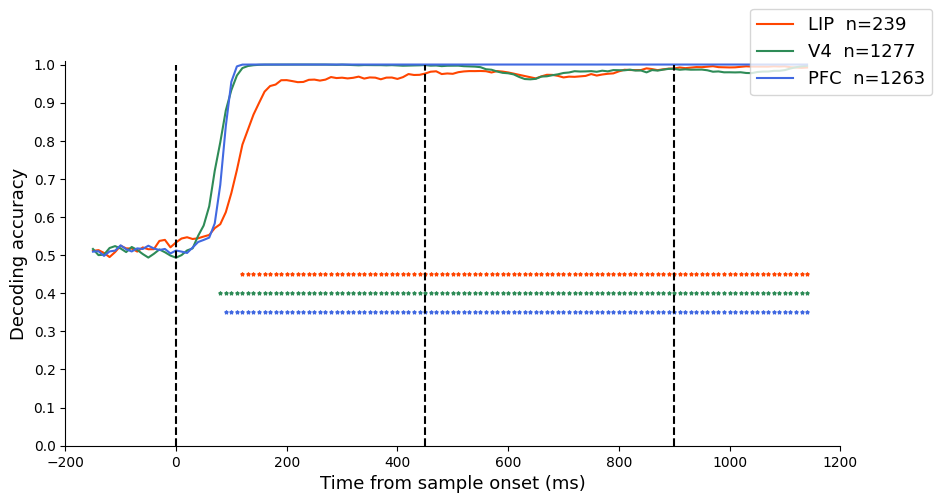

In [ ]:
path_lip = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_neutral_1000it_all_in_win100.npy'
path_v4 = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/v4_neutral_1000it_all_in_win100.npy'
path_pfc = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/pfc_neutral_1000it_all_in_win100.npy'
#path_test = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/lip_test.npy'
color=["#ff4500",'seagreen','royalblue']#,'y']
to_decode = "neutral"
n_neurs=[239,1277,1263,112]
fig,ax = plt.subplots(figsize=(10,5))
for i,(path,area) in enumerate(zip([path_lip,path_v4,path_pfc],["LIP","V4","PFC"])):
    area = area + '  n='+ str(n_neurs[i])
    scores=np.load(path)[:,:130]
    x = ((np.arange(0, len(scores[0]))) - (fix_duration-50) / step) * 10
    ax.plot(x, np.array(scores).mean(axis=0), label=area,color=color[i])
    if to_decode == "samples":
        threshole = 0.25
    else:
        threshole = 0.5
    ss = np.sum(np.array(scores) <= threshole, axis=0) / np.array(scores).shape[0]
    mask_inf = ss <= 0.01
    mask_inf_5 = ss <= 0.05
    # stars
    ax.scatter(
        x[mask_inf_5],
        [threshole+0.05 - (0.1+i/20)] * len(x[mask_inf_5]),
        color=color[i],
        marker="*",
        s=6,
    )
    ax.set_ylim(0, 1.01)
    ax.set_xlim(-200,1200)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    # delete boundaries
    ax.spines["right"].set_visible(False)
    #ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #ax.spines["bottom"].set_visible(False)
ax.vlines([0,450,900],0,1,'k','--')
ax.set_xlabel('Time from sample onset (ms)',fontsize=13)
ax.set_ylabel('Decoding accuracy',fontsize=13)
fig.legend(fontsize=13)

    # fig.suptitle(
    #     "%s, condition: %s, group: %s, %d neurons,window: %d, steps: %d"
    #     % (s_path[-2], in_out, cgroup, n_neurons, win_size, step)
    # )

In [ ]:
fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_neutral_areas.png",format='png',bbox_inches="tight", transparent=True)
fig.savefig("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/decoding_new/"+"decoding_neutral_areas.svg",format='svg',bbox_inches="tight", transparent=True)

In [ ]:
path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/session_struct/Riesling/lip/2023-02-24_10-43-44_Riesling_lip_e1_r1_lfp.h5"
path_bhv="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/2023-02-24_10-43-44_Riesling_e1_r1_bhv.h5"

In [ ]:
data = LfpData.from_python_hdf5(path)
data_bhv = BhvData.from_python_hdf5(path_bhv)

In [ ]:
np.sum(~np.isnan(data_bhv.code_samples[:,19]))

28

In [ ]:
data_bhv.code_samples

array([[  0.,  22., 288., ...,  nan,  nan,  nan],
       [  0.,  14., 829., ...,  nan,  nan,  nan],
       [  0.,  11., 210., ...,  nan,  nan,  nan],
       ...,
       [  0.,   3.,  14., ...,  nan,  nan,  nan],
       [  0.,   3.,  15., ...,  nan,  nan,  nan],
       [  0.,   2.,  15., ...,  nan,  nan,  nan]])

In [ ]:
idx_end = data_bhv.code_samples[data_bhv.code_numbers==config.END_CODE]+data.idx_start

In [ ]:
idx_end

array([  10403.,   14912.,   18803., ..., 4663365., 4669836., 4672661.])

In [ ]:
data_bhv.idx_end-data_bhv.idx_start

array([ 8, 12, 12, ...,  4,  6,  8])

array([    0,     9,    22, ..., 14447, 14452, 14459])

In [ ]:
data.lfp_values

array([[-1.07100607e-07, -3.21782751e+00, -6.91268514e+01, ...,
         2.03130599e+02,  2.33460789e+02,  2.70880694e+02],
       [-1.02735093e-07, -3.20197655e+00, -6.90712172e+01, ...,
         2.07734659e+02,  2.46400668e+02,  2.74122870e+02],
       [-9.69144078e-08, -3.25902340e+00, -7.12993968e+01, ...,
         2.13506597e+02,  2.32263993e+02,  2.46838478e+02],
       ...,
       [-4.10358303e-08, -1.27390438e+00, -2.40755918e+01, ...,
         3.42992741e+01,  4.27354409e+01,  6.43453258e+01],
       [-3.60882479e-08, -1.32248436e+00, -2.62762506e+01, ...,
         1.58938059e+01,  4.98515376e+01,  8.04114457e+01],
       [-3.98716933e-08, -9.49191925e-01, -2.23914711e+01, ...,
         4.34183310e+01,  7.66514552e+01,  1.21637305e+02]])

In [ ]:
path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct_test/session_struct/Riesling/lip/2023-02-24_10-43-44_Riesling_lip_e1_r1_spike.h5"

In [ ]:
sp_data = SpikeData.from_python_hdf5(path)

In [ ]:
sp_data.start_trials

array([2341790, 2345881, 2350390, ..., 6992313, 6998843, 7005314])

In [ ]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if result.shape[-1] == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result


In [ ]:
seq = np.array([[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],[0,3,2,3,4,5,6,7,8,9,30,33,32,33,34,35,36,37,38,39,20]])

In [ ]:
result = np.lib.stride_tricks.sliding_window_view(seq, window_shape=2, axis=1, subok=False, writeable=False)

In [ ]:
it = iter(seq)
result = tuple(islice(it, 2))

In [ ]:
a=window(seq, n=2)

In [ ]:
next(a)

StopIteration: 

In [ ]:
bhv = BhvData.from_matlab_mat("/envau/work/invibe/USERS/IBOS/openephys/Riesling/2023-03-30_10-36-53/Record Node 102/experiment1/recording1/230330_TSCM_5cj_5cl_Riesling.mat")

In [ ]:
bhv.eye_ml.shape

(1104, 3, 7985)

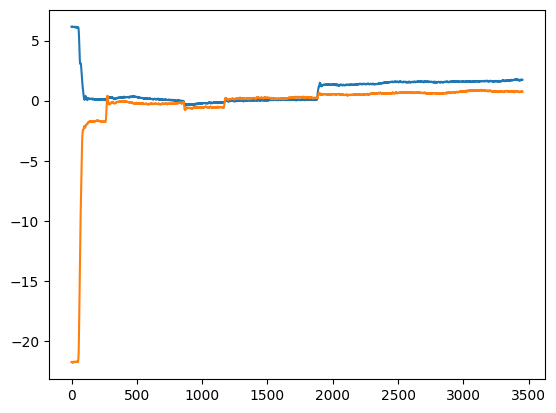

In [ ]:
plt.plot(bhv.eye_ml[256][0])
plt.plot(bhv.eye_ml[256][1])

In [ ]:
data_path = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2022-11-28_10-23-27_Riesling_lip_e1_r1.h5"
s_path = os.path.normpath(data_path).split(os.sep)

In [ ]:
s_path[-1][:-3]

'2022-11-28_10-23-27_Riesling_lip_e1_r1'

In [ ]:
cluster_info = pd.read_csv(
        "/envau/work/invibe/USERS/IBOS/openephys/Riesling/2022-11-28_10-23-27/Record Node 102/experiment1/recording1/continuous/Acquisition_Board-100.Rhythm Data/KSLIP" + "/cluster_info.tsv", sep="\t"
    ) 

In [ ]:
np.sum(cluster_info["group"].values!='noise')

14

In [ ]:
cluster_info["group"].values

array(['noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'noise',
       'noise', 'noise', 'noise', 'noise', 'noise', 'noise', 'mua',
       'noise', 'noise', 'noise', 'mua', 'noise', 'noise', 'noise',
       'noise', 'noise', 'mua', 'noise', 'noise', 'mua', 'noise', 'noise',
       'noise', 'noise', 'mua', 'noise', 'mua', 'noise', 'mua', 'noise',
       'noise', 'noise', 'noise', 'noise', 'good', 'noise', 'noise',
       'good', 'noise', 'good', 'noise', 'mua', 'noise', 'noise', 'noise',
       'noise', 'mua', 'mua', 'mua'], dtype=object)

In [ ]:
b=vars(bhv).copy()
for key,val in b.items():
    if val.shape[0]==n_trials:
        b[key]=val[:2]
    else:
        print(val.shape)
b=BhvData(**b)

In [ ]:
path = "/home/INT/losada.c/Documents/data/test/2022-11-28_10-23-27_Riesling_lip_e1_r1.h5"
data = TrialsData.from_python_hdf5(path)

In [ ]:
data.neuron_cond

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2])

## roc

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from statsmodels.stats.multitest import multipletests
from sklearn.multiclass import OneVsRestClassifier
from statsmodels import api as sm
from statsmodels.formula.api import ols
from bioinfokit. analys import stat as bk_stat
from sklearn.metrics import roc_auc_score
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.trials_data import TrialsData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants,def_task
import os 
from matplotlib import cm
seed = 2023

In [ ]:
path = '/home/INT/losada.c/Documents/codes/EphysVibe/examples/v4/2022-12-05_10-51-52_Riesling_v4_e1_r1'

In [ ]:
all_mag = np.load(path+'_mag.npy')
all_ang = np.load(path+'_ang.npy')
p_color_all = np.load(path+'_p_color.npy')
p_orient_all = np.load(path+'_p_orient.npy')
neuron = np.load(path+'_neuron.npy')

In [ ]:
def scale_mag(x, out_range=(0.05, 1)):
    domain = 0.2, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [ ]:
quant_steps=360*2
cmap=cm.get_cmap('hsv',quant_steps)

f_all_mag=np.where(np.array(all_mag)>1,1.,np.array(all_mag))
lim = 0.2
mask=f_all_mag<lim
f_all_mag = scale_mag(f_all_mag)
f_all_mag = np.where(f_all_mag<0,0,f_all_mag)

In [ ]:
def find_significant(p_value:np.ndarray,win:int, step:int=1)-> np.ndarray:

    p_shape=p_value.shape
    sign = np.zeros((p_shape[0],int(np.floor(p_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,p_shape[1]-step,step):
        sign[:,count] = np.where(np.all(p_value[:,i_step:i_step+win]<0.01,axis=1),True,False)
        count +=1
    return sign

In [ ]:
step=1
win=30
s_color = find_significant(p_value=p_color_all,win=win, step=step)
s_orient = find_significant(p_value=p_orient_all,win=win, step=step)

no_sig = np.where(np.sum(s_orient,axis=1)==0)[0]
if len(no_sig)!=0:
    s_orient[no_sig,-1]=np.nan
no_sig = np.where(np.sum(s_color,axis=1)==0)[0]
if len(no_sig)!=0:
    s_color[no_sig,-1]=np.nan

orient_max = np.nanargmax(s_orient,axis=1)
orient_max=np.where(np.logical_and(orient_max==0,np.isnan(s_orient[:,-1])),np.nan,orient_max)
color_max = np.nanargmax(s_color,axis=1)
color_max=np.where(np.logical_and(color_max==0,np.isnan(s_color[:,-1])),np.nan,color_max)

In [ ]:
neuron[idx_c_o_sort][104]

'neuron25_2022-12-14_10-50-49_Riesling_pfc_e1_r1'

/tmp/ipykernel_14324/3758392118.py:4: RuntimeWarning: All-NaN axis encountered
  c_o_max = np.nanmin([color_max,orient_max],axis=0)


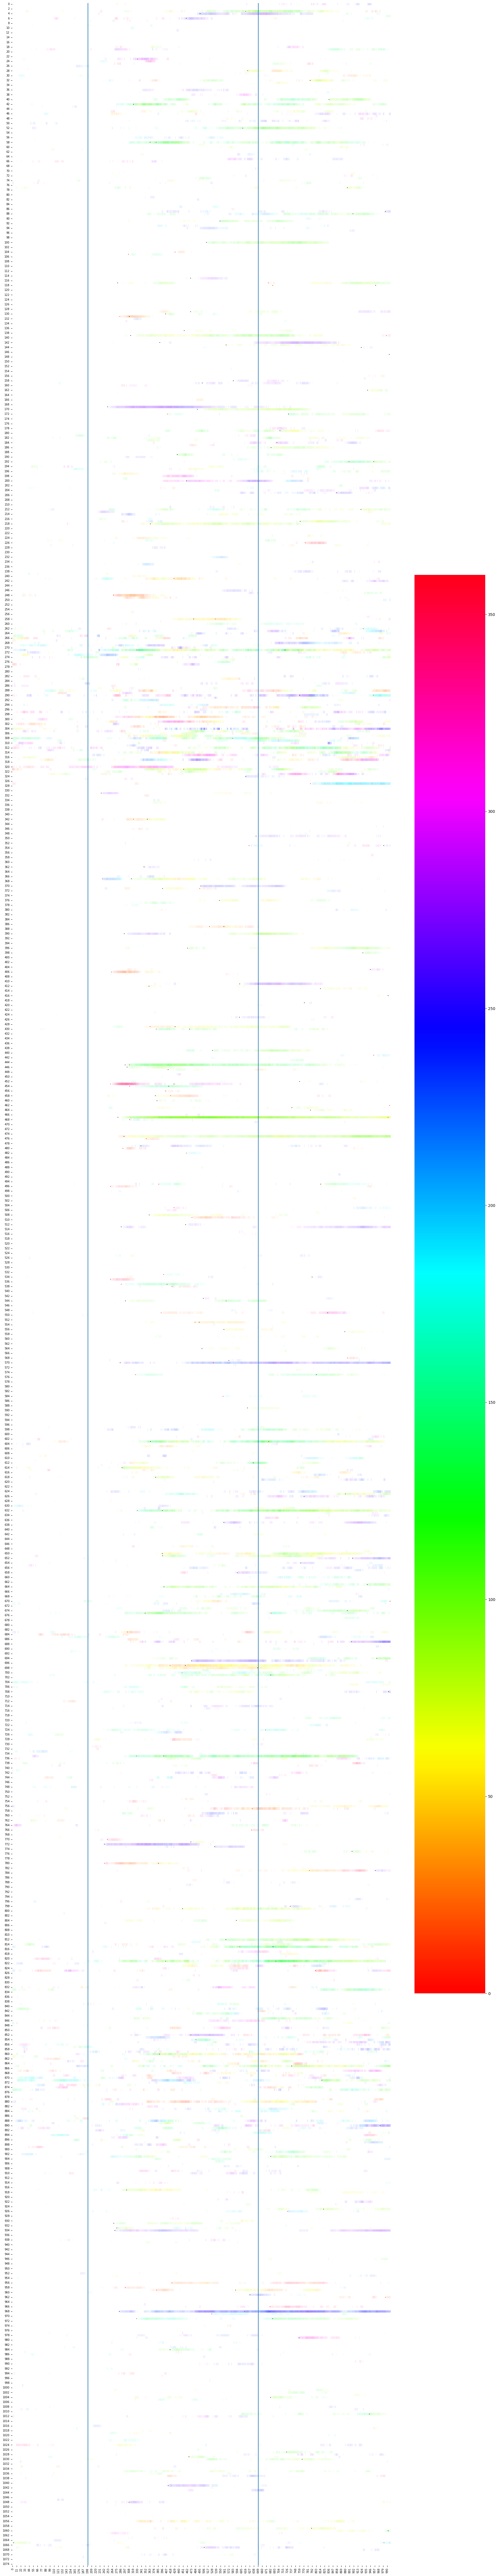

In [ ]:
c_o_mask = np.argmin([color_max,orient_max],axis=0)
c_mask = c_o_mask==0
o_mask = c_o_mask == 1
c_o_max = np.nanmin([color_max,orient_max],axis=0)
idx_c_o_sort = np.argsort(c_o_max)
#idx_c_o_sort=idx_c_o_sort[c_o_max[idx_c_o_sort]!=0]

fig,ax = plt.subplots(figsize=(22,120))
#ax.vlines([200,650],0,200)
ax = sns.heatmap(np.array(all_ang),cmap=cmap,vmin=0,vmax=360,alpha=f_all_mag,mask=mask,ax=ax)#,yticklabels=np.arange(len(all_ang)))

ax.scatter(color_max,np.arange(len(c_o_max))+0.5,marker='|',color='r',label='color',s=4)
ax.scatter(orient_max,np.arange(len(c_o_max))+0.5,marker='|',color='k',label='orientation',s=4)
# ax.set_xticks(np.arange(0,len(all_ang[0]),5).tolist())
# ax.set_xlabel(pp)
ax.tick_params(labelsize=7)
ax.vlines([200,650],0,1075)
#ax.scatter(c_o_max,np.arange(len(c_o_max))+0.5,marker='|')
#ax.set_yticks(np.arange(len(all_ang)))
#g.set_ylabel(np.array(np.arange(len(all_ang)),dtype=str))
# ax.set_xlabel(np.arange(-200,len(all_ang[0])-200))
#fig.legend(fontsize=9)
plt.show()

/tmp/ipykernel_14324/4019670567.py:4: RuntimeWarning: All-NaN axis encountered
  c_o_max = np.nanmin([color_max,orient_max],axis=0)


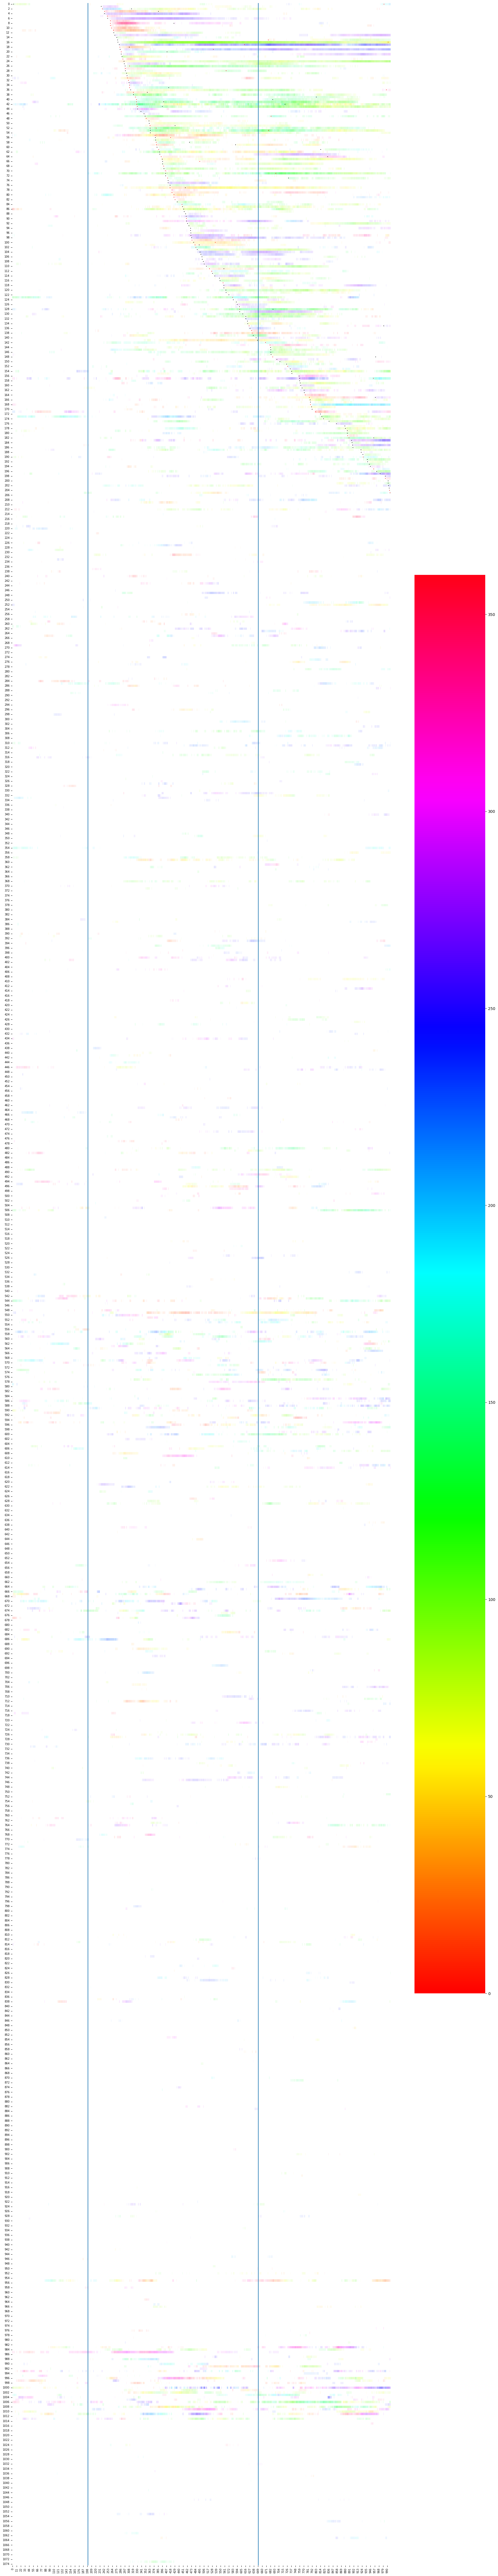

In [ ]:
c_o_mask = np.argmin([color_max,orient_max],axis=0)
c_mask = c_o_mask==0
o_mask = c_o_mask == 1
c_o_max = np.nanmin([color_max,orient_max],axis=0)
idx_c_o_sort = np.argsort(c_o_max)
#idx_c_o_sort=idx_c_o_sort[c_o_max[idx_c_o_sort]!=0]

fig,ax = plt.subplots(figsize=(22,120))
#ax.vlines([200,650],0,200)
ax = sns.heatmap(np.array(all_ang)[idx_c_o_sort],cmap=cmap,vmin=0,vmax=360,alpha=f_all_mag[idx_c_o_sort],mask=mask[idx_c_o_sort],ax=ax)#,yticklabels=np.arange(len(all_ang[idx_c_o_sort])))

ax.scatter(color_max[idx_c_o_sort],np.arange(len(c_o_max[idx_c_o_sort]))+0.5,marker='|',color='r',label='color',s=4)
ax.scatter(orient_max[idx_c_o_sort],np.arange(len(c_o_max[idx_c_o_sort]))+0.5,marker='|',color='k',label='orientation',s=4)
# ax.set_xticks(np.arange(0,len(all_ang[0]),5).tolist())
# ax.set_xlabel(pp)
ax.tick_params(labelsize=7)
ax.vlines([200,650],0,1075)
#ax.scatter(c_o_max[idx_c_o_sort],np.arange(len(c_o_max[idx_c_o_sort]))+0.5,marker='|')
#ax.set_yticks(np.arange(len(all_ang)))
#g.set_ylabel(np.array(np.arange(len(all_ang)),dtype=str))
# ax.set_xlabel(np.arange(-200,len(all_ang[0])-200))
#fig.legend(fontsize=9)
plt.show()

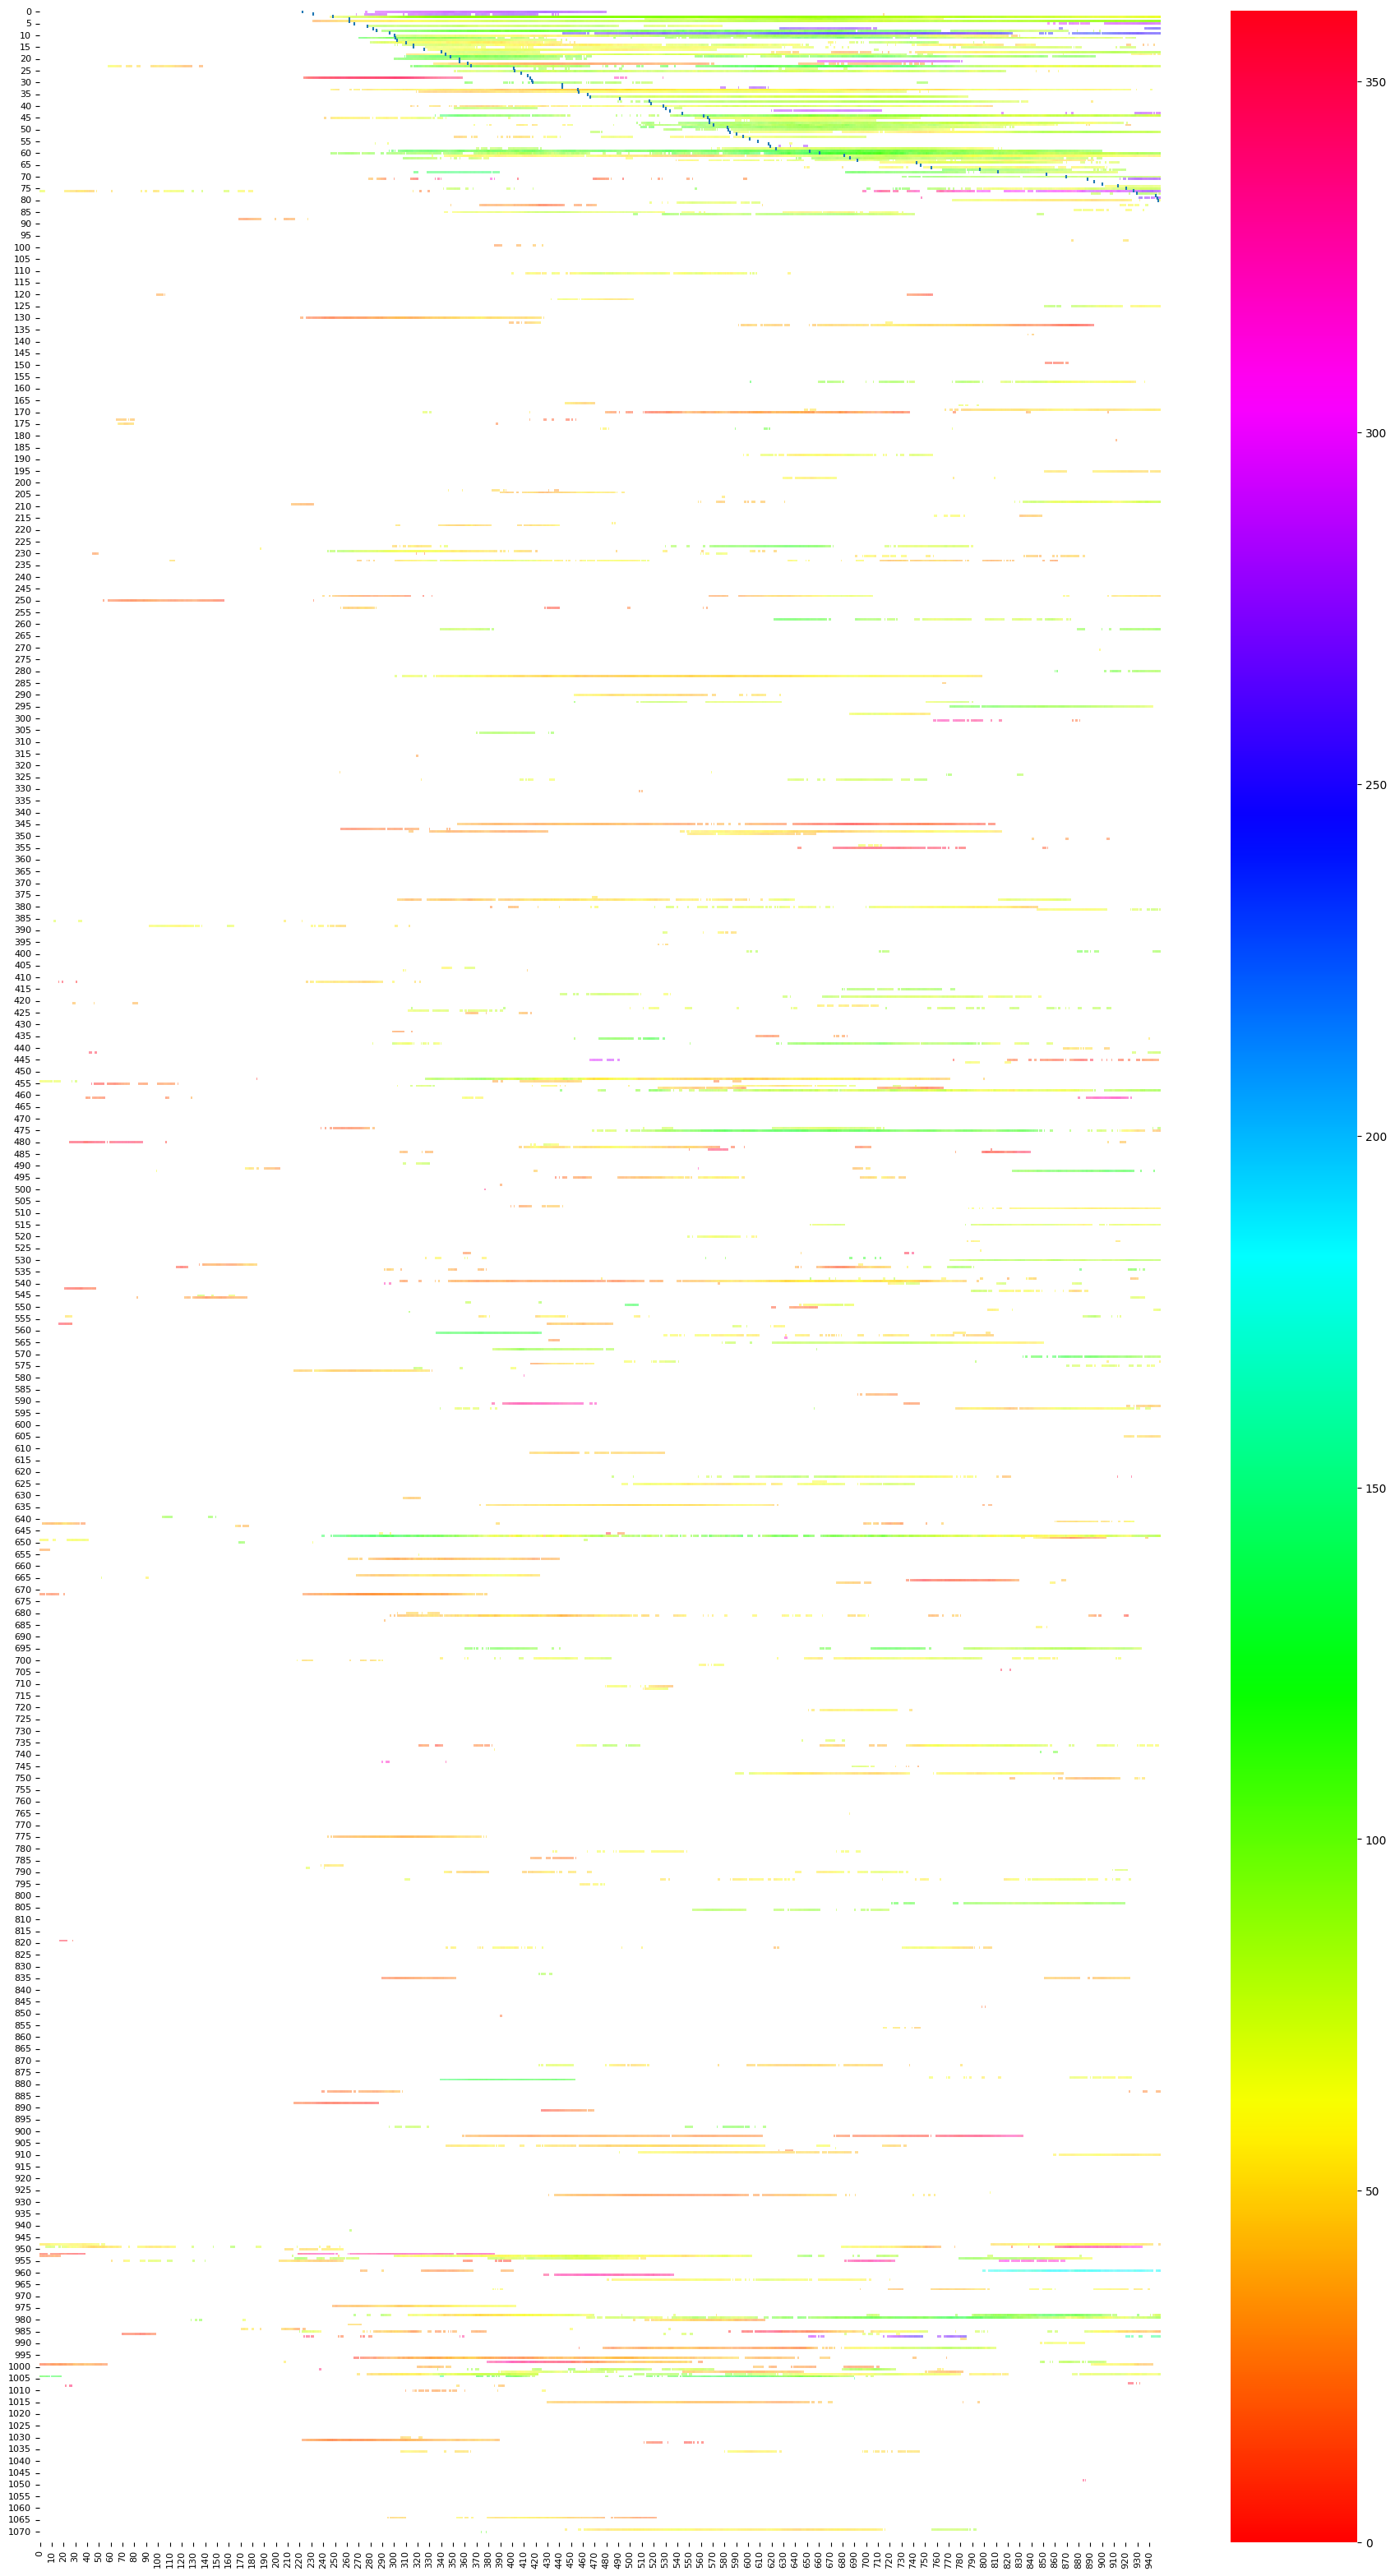

In [ ]:
idx_orient_sort = np.argsort(orient_max)
#idx_orient_sort=idx_orient_sort[orient_max[idx_orient_sort]!=0]

fig,ax = plt.subplots(figsize=(22,40))
#ax.vlines([200,650],0,200)
g = sns.heatmap(np.array(all_ang)[idx_orient_sort],cmap=cmap,vmin=0,vmax=360,alpha=f_all_mag[idx_orient_sort],mask=mask[idx_orient_sort],ax=ax)#,yticklabels=np.arange(len(all_ang[idx_orient_sort])))
g.tick_params(labelsize=8)
ax.scatter(orient_max[idx_orient_sort],np.arange(len(orient_max[idx_orient_sort]))+0.5,marker='|',s=5)
#ax.set_yticks(np.arange(len(all_ang)))
#g.set_ylabel(np.array(np.arange(len(all_ang)),dtype=str))
# ax.set_xlabel(np.arange(-200,len(all_ang[0])-200))
plt.show()

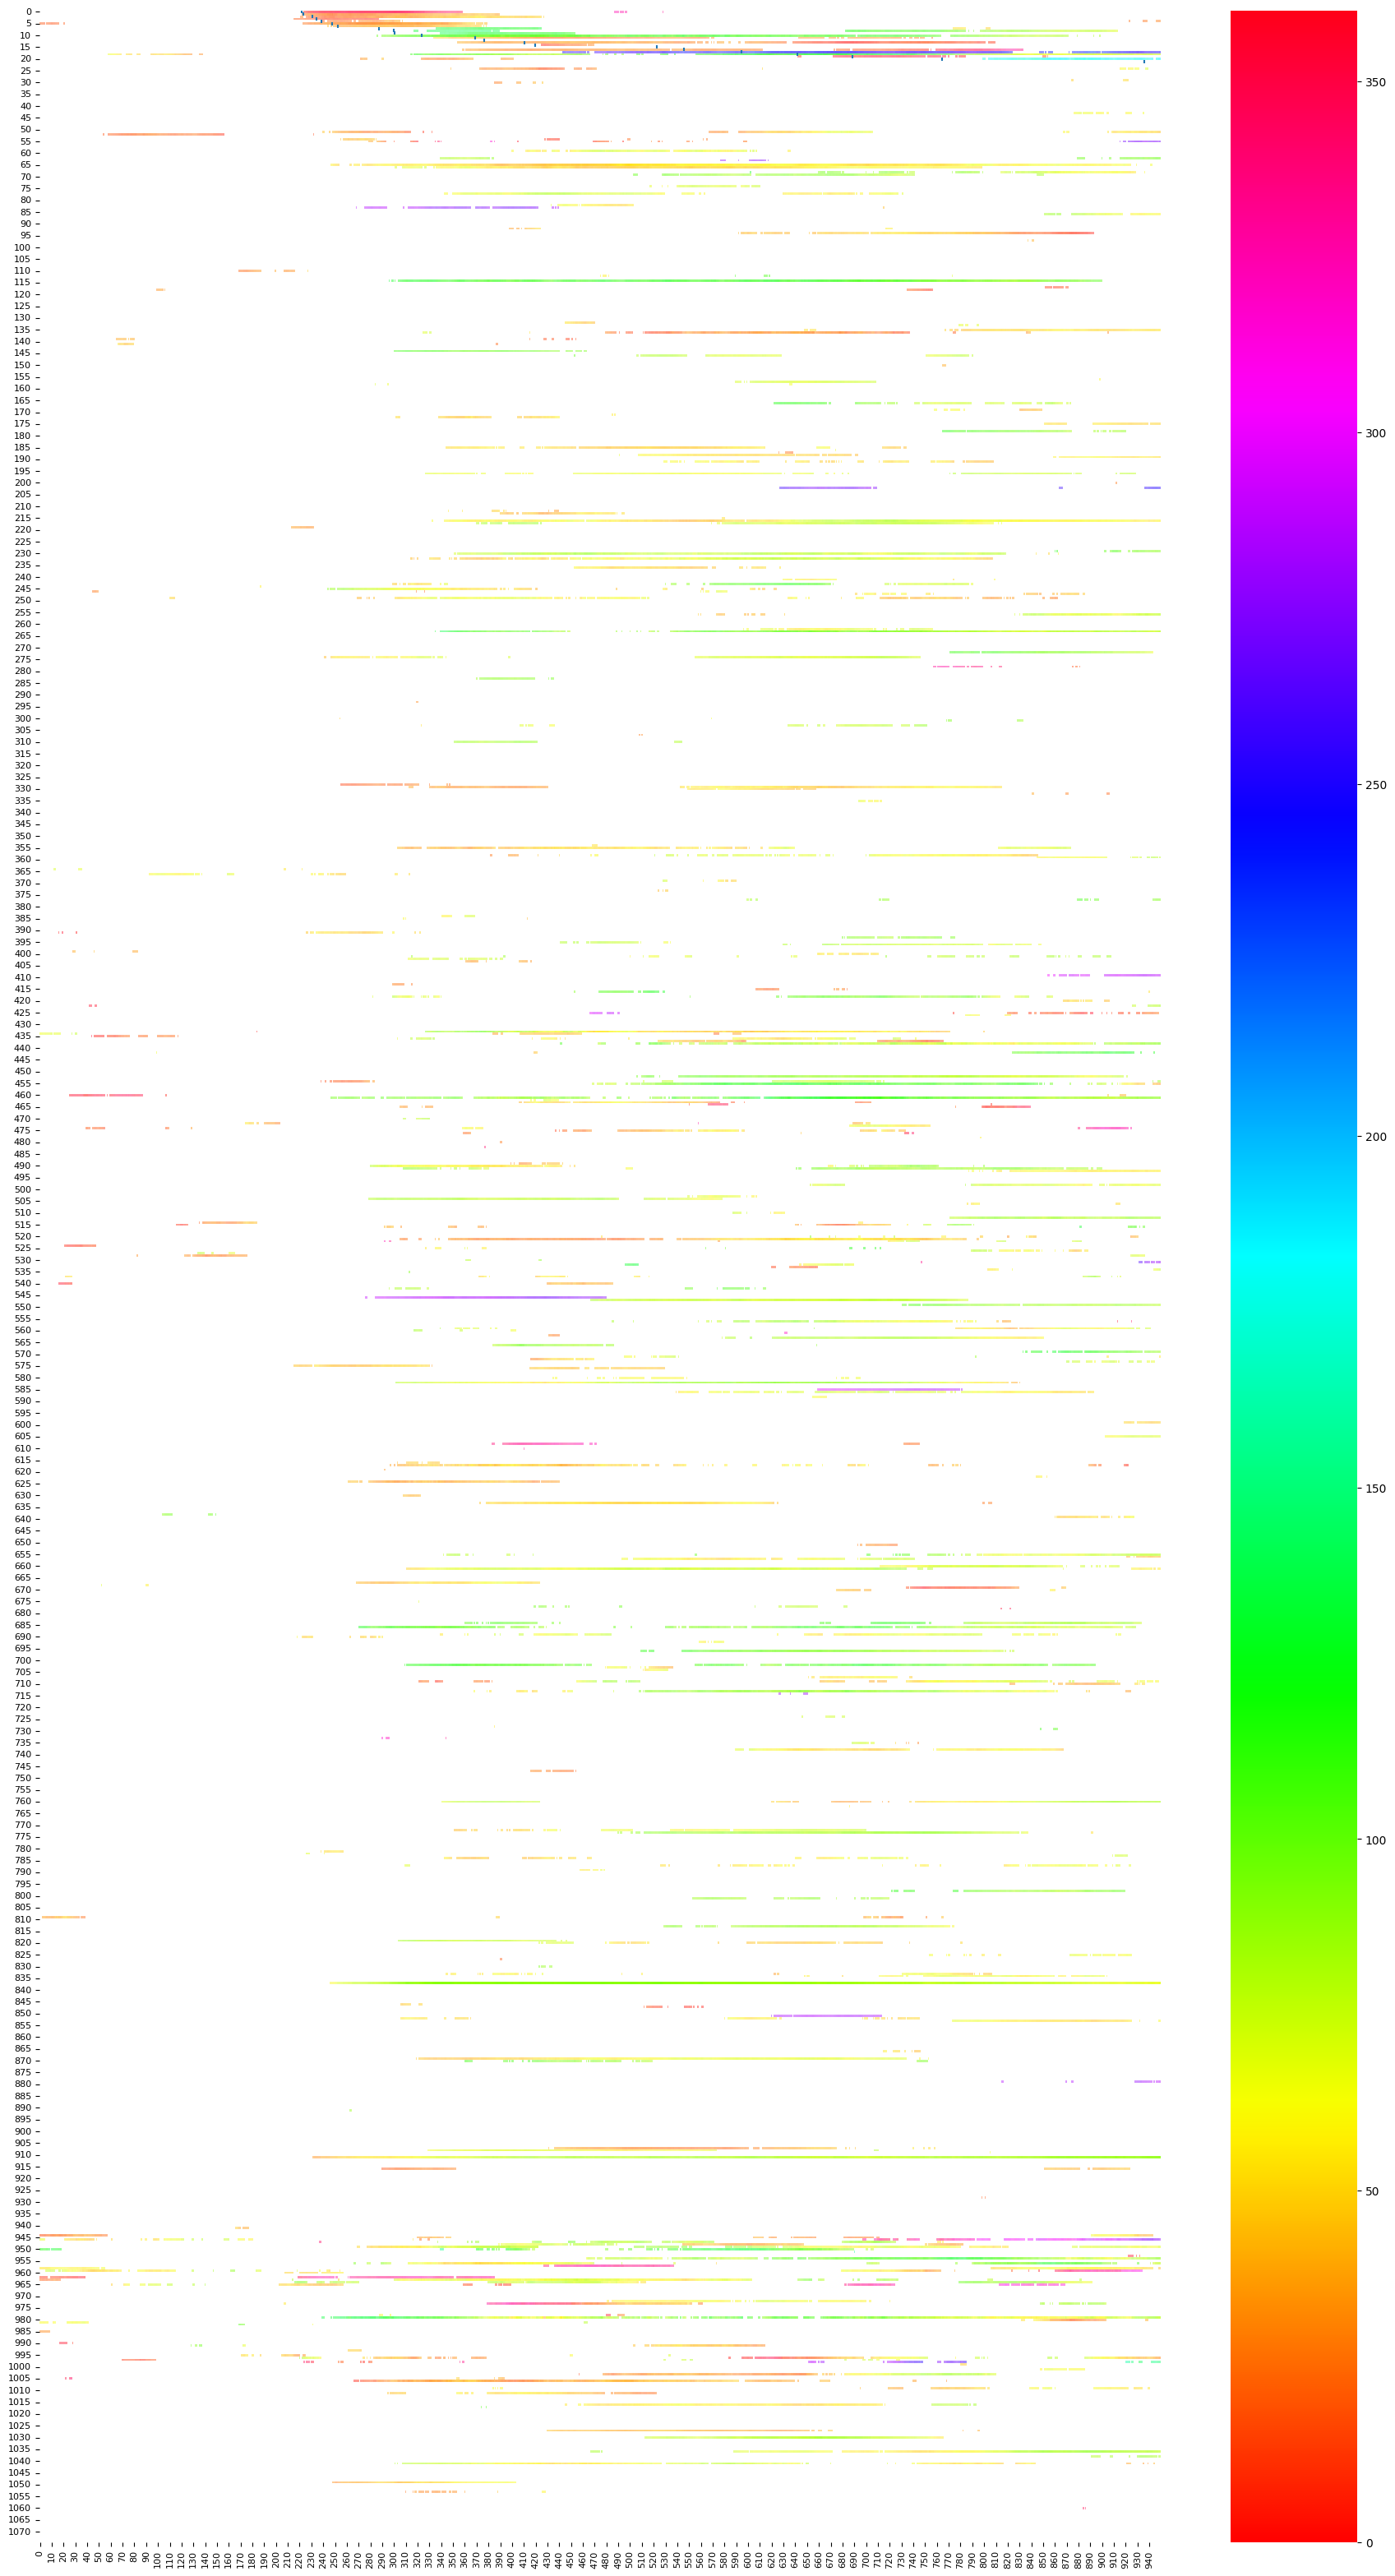

In [ ]:
idx_color_sort = np.argsort(color_max)
#idx_color_sort=idx_color_sort[color_max[idx_color_sort]!=0]

fig,ax = plt.subplots(figsize=(22,40))
#ax.vlines([200,650],0,200)
g = sns.heatmap(np.array(all_ang)[idx_color_sort],cmap=cmap,vmin=0,vmax=360,alpha=f_all_mag[idx_color_sort],mask=mask[idx_color_sort],ax=ax)#,yticklabels=np.arange(len(all_ang[idx_color_sort])))
g.tick_params(labelsize=8)
ax.scatter(color_max[idx_color_sort],np.arange(len(color_max[idx_color_sort]))+0.5,marker='|',s=5)
#ax.set_yticks(np.arange(len(all_ang)))
#g.set_ylabel(np.array(np.arange(len(all_ang)),dtype=str))
# ax.set_xlabel(np.arange(-200,len(all_ang[0])-200))
plt.show()

In [ ]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [ ]:
data = TrialsData.from_python_hdf5("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/v4/2022-12-05_10-51-52_Riesling_v4_e1_r1.h5")

In [ ]:
data.neuron_cond[8]

IndexError: index 8 is out of bounds for axis 0 with size 1

In [ ]:
alias meso='ssh -p 8822 gibos@login.mesocentre.univ-amu.fr'
alias mmesoh='sshfs -p 8822 -o idmap=user gibos@login.mesocentre.univ-amu.fr:/home/gibos/ /home/gibos/disks/meso_H'
alias umesoh='fusermount -u /home/gibos/disks/meso_H'

alias mmesos='sshfs -p 8822 -o idmap=user gibos@login.mesocentre.univ-amu.fr:/scratch/gibos/ /home/gibos/disks/meso_S'
alias umesos='fusermount -u /home/gibos/disks/meso_S'

'good'

In [ ]:
i_neuron=24
t_before = 200
t_after = 950
in_out='in'
trials_b1 = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
shifts = data.code_samples[
    trials_b1,
    np.where(data.code_numbers[trials_b1] == task_constants.EVENTS_B1["sample_on"])[
        1
    ],
]-t_before

roll_sp = TrialsData.indep_roll(data.sp_samples[trials_b1,i_neuron],shifts=-shifts.astype(int), axis=1)[:,:t_after+t_before]
if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond=data.neuron_cond
task = def_task.create_task_frame(
    condition=data.condition[trials_b1],
    test_stimuli=data.test_stimuli[trials_b1],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond = neuron_cond,
)
task = task[(task['i_neuron']==i_neuron)&(task['in_out']==in_out)]

c1_trials = task[task['sample'].str.contains('c1', case=False)]['trial_idx'].values
c5_trials = task[task['sample'].str.contains('c5', case=False)]['trial_idx'].values
o1_trials = task[task['sample'].str.contains('o1', case=False)]['trial_idx'].values
o5_trials = task[task['sample'].str.contains('o5', case=False)]['trial_idx'].values
c0_trials = task[task['sample'].str.contains('c0', case=False)]['trial_idx'].values

win = 150
step = 1
avg_sp = moving_average(data=roll_sp,win=win, step=step)[:,:-win]

c1_sp = avg_sp[c1_trials] 
c5_sp = avg_sp[c5_trials] 
o1_sp = avg_sp[o1_trials] 
o5_sp = avg_sp[o5_trials] 
c0_sp = avg_sp[c0_trials] 

#color = compute_roc_auc(c1_sp,c5_sp)
#orient = compute_roc_auc(o1_sp,o5_sp)
group1 = c1_sp
group2 = c5_sp
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(np.arange(0,1,0.1).reshape(-1, 1))
rng = np.random.default_rng(seed=seed)
#it_seed = rng.integers(low=1, high=2023, size=a.shape[1], dtype=int)
roc_score,p = [],[]
for n_win in np.arange(0,group1.shape[1]):#
    g1 = group1[:,n_win]
    g2 = group2[:,n_win]
    # t-test
    p.append(stats.ranksums(g1, g2)[1])
    min_fr, max_fr = np.concatenate([g1,g2]).min(),np.concatenate([g1,g2]).max()
    thresholds = np.arange(min_fr,max_fr+0.01,0.01)
    y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
    score=0.5
    fpr,tpr=[],[]
    for threshold in thresholds:
        g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
        g1_mask,g2_mask = g1>=threshold,g2>=threshold
        g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
        tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
        fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
        tpr.append(tp/ (tp+fn) )
        fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
        tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
        fpr.append(fp/ (fp+tn) )
    if len(fpr) > 1:
        fpr,tpr=np.array(fpr),np.array(tpr)
        idx_sort=fpr.argsort()
        score = metrics.auc(fpr[idx_sort],tpr[idx_sort])
        roc_score.append(score)
    else:
        roc_score.append(score)
roc_score=np.array(roc_score)
roc_score=scaler.transform(roc_score.reshape(-1, 1)).squeeze()

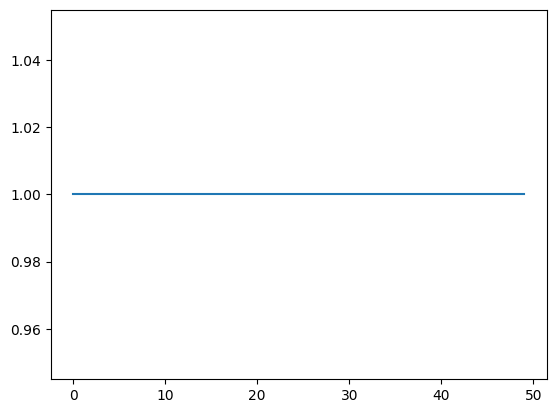

In [ ]:
plt.plot(p[:50])

In [ ]:
c1_sp.shape

(93, 1100)

In [ ]:
c5_sp.shape

(97, 1100)

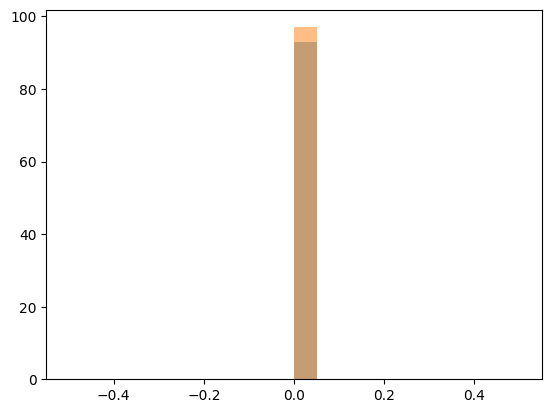

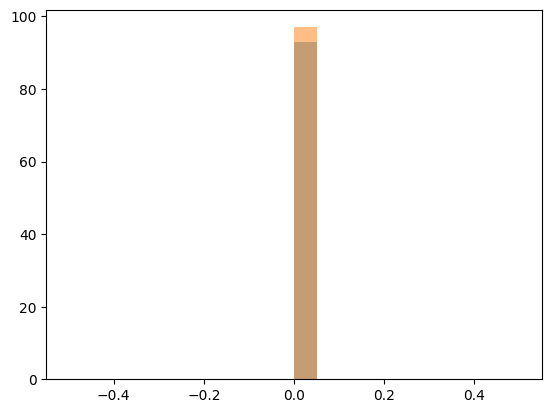

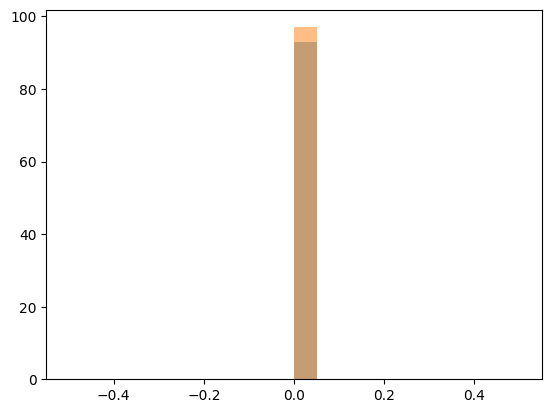

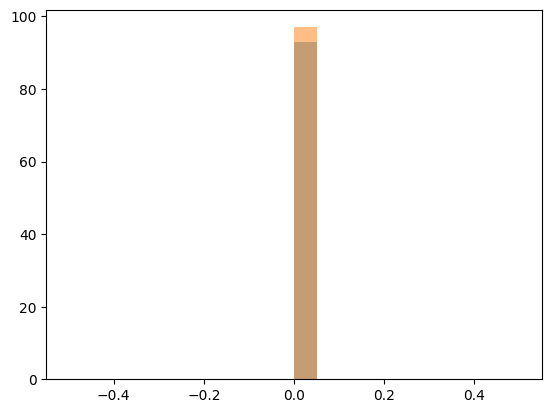

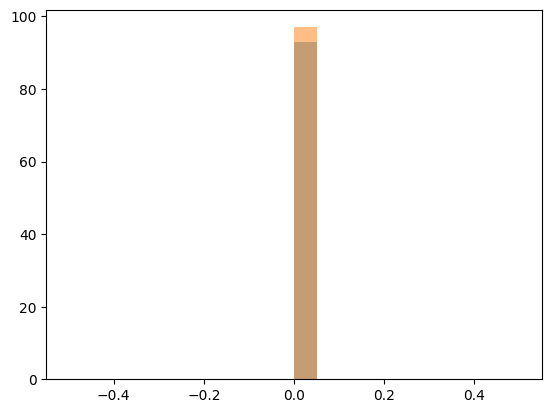

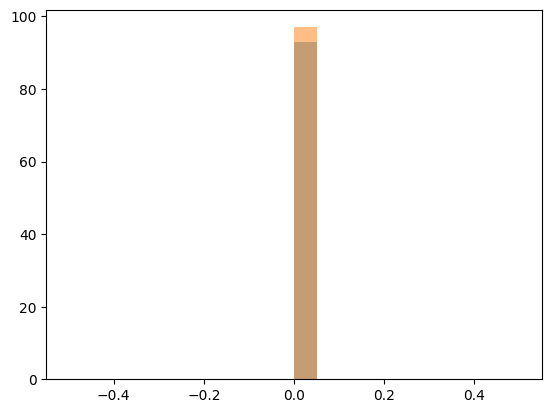

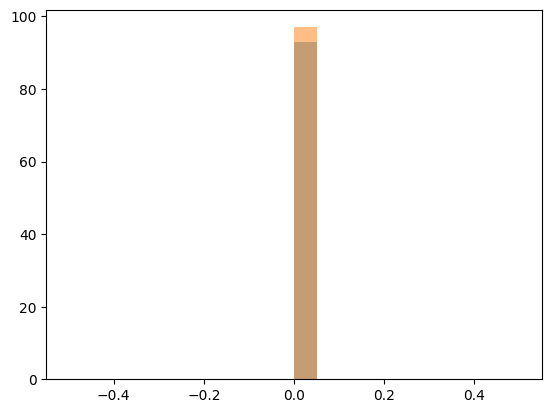

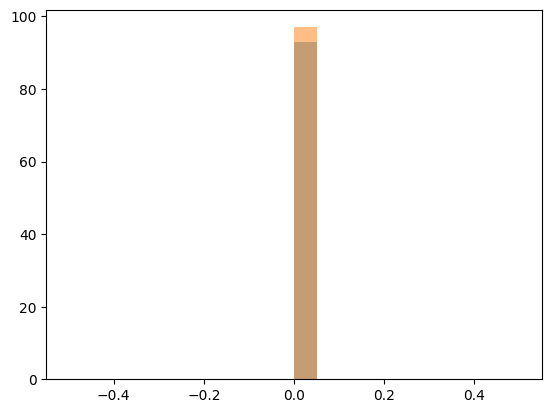

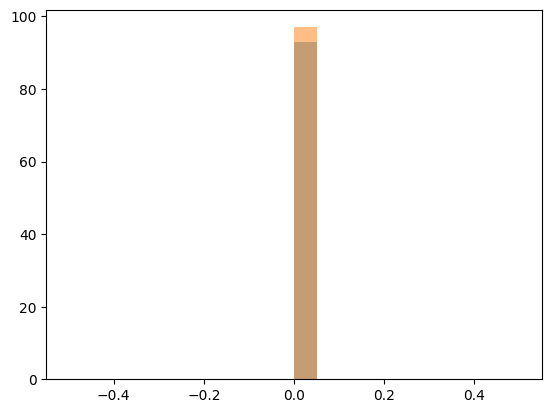

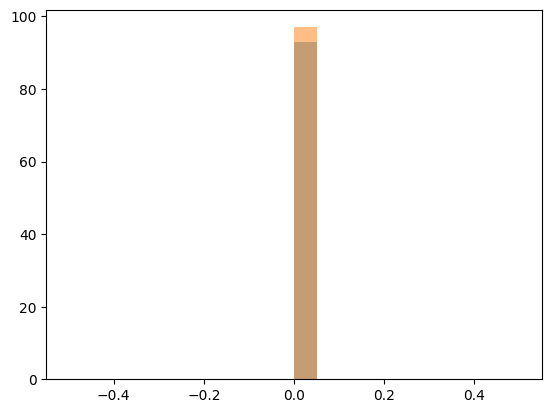

In [ ]:
for n_win in np.arange(0,10):#
    fig,ax = plt.subplots()
    ax.hist(c1_sp[:,n_win],bins=20,alpha=0.5)
    ax.hist(c5_sp[:,n_win],bins=20,alpha=0.5)

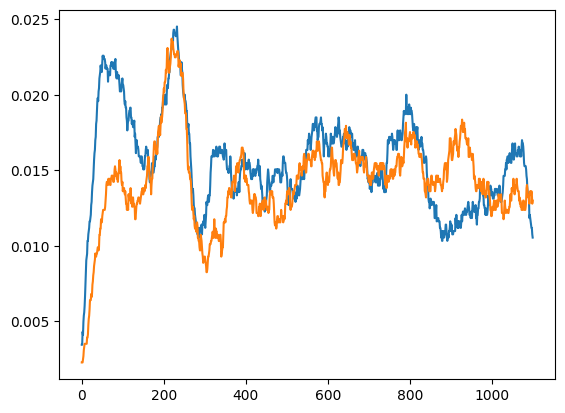

In [ ]:
plt.plot(np.mean(group1,axis=0))
plt.plot(np.mean(group2,axis=0))